In [1]:
import json
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Exploratory Data Analysis

## Ideas

How does our characterization of food differ across various dimensions of who we are? 

**Characterization of food**: 

- Authenticity
- "axes of evaluation": adjectives used to describe foods
    - sweetness (e.g. are east asian people more favoring less sweet, southerners favoring more sweet)
    - spiciness (e.g. are white people more critical of spicy)
- reviews involving "support" and slack/activism 
- specificity of regions / cuisines within reviews: "South Indian" vs. "Indian", "Chinese" vs. "Sichuan", "African" vs. "Ethipian" 
- how semantically distinct are people's desecriptions within categories of food
- portion size (ratio of blank plate to food on the plate)
- entities
    - are certain dishes called out in different regions (e.g. orange chicken in midwest and south vs. something different in other regions) 
    - food trends

**Differential axes**: 
- Geography
- Urban vs. rural 
- Pairings of cuisines: Soul Food vs. Southern, American vs. Mexican (time and border wall politics), Italian vs. Mexican
- Issue/event-based reviewing, Pakistani restaurant getting burned down in Minneapolis, did that change anything? 
- before and after receiving awards 
- immigration and establishment of cuisine times 
- demographics of zip code 
- college towns vs other towns

A possible alternative to the Yelp's Open Dataset if we wanted to specify what cities to focus on: 
https://www.yelp.com/developers/documentation/v3

In [2]:
df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [3]:
df.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [4]:
df = df[['business_id', 'city', 'state', 'postal_code', 'stars', 'review_count', 'categories']]
df = df[df['categories'].notna()]
df = df[df['categories'].str.contains("Restaurants")]
df['city_state'] = df['city'] + '_' + df['state']
df

,business_id,city,state,postal_code,stars,review_count,categories,city_state
3,MTSW4McQd7CbVtyjqoe9mw,Philadelphia,PA,19107,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",Philadelphia_PA
5,CF33F8-E6oudUQ46HnavjQ,Ashland City,TN,37015,2.0,6,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",Ashland City_TN
8,k0hlBqXX-Bt0vf1op7Jr1w,Affton,MO,63123,3.0,19,"Pubs, Restaurants, Italian, Bars, American (Tr...",Affton_MO
9,bBDDEgkFA1Otx9Lfe7BZUQ,Nashville,TN,37207,1.5,10,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",Nashville_TN
11,eEOYSgkmpB90uNA7lDOMRA,Tampa Bay,FL,33602,4.0,10,"Vietnamese, Food, Restaurants, Food Trucks",Tampa Bay_FL
...,...,...,...,...,...,...,...,...
150325,l9eLGG9ZKpLJzboZq-9LRQ,Clifton Heights,PA,19018,3.0,11,"Restaurants, Sandwiches, Convenience Stores, C...",Clifton Heights_PA
150327,cM6V90ExQD6KMSU3rRB5ZA,Boise,ID,83704,4.0,33,"Cafes, Juice Bars & Smoothies, Coffee & Tea, R...",Boise_ID
150336,WnT9NIzQgLlILjPT0kEcsQ,Philadelphia,PA,19147,4.5,35,"Restaurants, Mexican",Philadelphia_PA
150339,2O2K6SXPWv56amqxCECd4w,Aston,DE,19014,4.5,14,"Restaurants, Comfort Food, Food, Food Trucks, ...",Aston_DE


In [6]:
restaurant_businesses = set(df['business_id'].to_list())
with open('restaurant_businesses.txt', 'w') as outfile: 
    for restaurant in tqdm(restaurant_businesses): 
        outfile.write(restaurant + '\n')

100%|████████████████████████████████████████████████████████████████████████████████████████| 52268/52268 [00:00<00:00, 563340.46it/s]


**Most common cities**

In [143]:
city_counts = Counter(df.city_state.value_counts().to_dict())
print(city_counts.most_common(100))

[('Philadelphia_PA', 5852), ('Tampa_FL', 2960), ('Indianapolis_IN', 2862), ('Nashville_TN', 2502), ('Tucson_AZ', 2466), ('New Orleans_LA', 2259), ('Edmonton_AB', 2166), ('Saint Louis_MO', 1790), ('Reno_NV', 1286), ('Boise_ID', 847), ('Santa Barbara_CA', 767), ('Clearwater_FL', 678), ('Wilmington_DE', 619), ('St. Louis_MO', 542), ('Metairie_LA', 522), ('Saint Petersburg_FL', 491), ('Franklin_TN', 442), ('St. Petersburg_FL', 404), ('Sparks_NV', 334), ('Brandon_FL', 326), ('Meridian_ID', 312), ('Largo_FL', 310), ('Cherry Hill_NJ', 297), ('Carmel_IN', 291), ('West Chester_PA', 280), ('Kenner_LA', 228), ('New Port Richey_FL', 226), ('Goleta_CA', 220), ('Palm Harbor_FL', 207), ('Greenwood_IN', 207), ('Fishers_IN', 203), ('Riverview_FL', 198), ('Trenton_NJ', 192), ('Dunedin_FL', 188), ('Hendersonville_TN', 183), ('Lutz_FL', 178), ('Pinellas Park_FL', 167), ('Smyrna_TN', 167), ('Florissant_MO', 165), ('Bensalem_PA', 165), ('Norristown_PA', 161), ('Wesley Chapel_FL', 158), ('Brentwood_TN', 156)

In [7]:
categories = df.categories.to_list()
category_counts = Counter()
for cat in categories: 
    category_counts.update(cat.split(', '))
print(category_counts.most_common(100))

[('Restaurants', 52268), ('Food', 15472), ('Nightlife', 8723), ('Sandwiches', 8366), ('Bars', 8337), ('American (Traditional)', 8139), ('Pizza', 7093), ('Fast Food', 6472), ('Breakfast & Brunch', 6239), ('American (New)', 6097), ('Burgers', 5636), ('Mexican', 4600), ('Italian', 4573), ('Coffee & Tea', 4053), ('Seafood', 3539), ('Chinese', 3169), ('Event Planning & Services', 3068), ('Salad', 3064), ('Chicken Wings', 2966), ('Cafes', 2756), ('Delis', 2393), ('Caterers', 2059), ('Specialty Food', 2011), ('Bakeries', 1889), ('Desserts', 1838), ('Japanese', 1830), ('Sports Bars', 1797), ('Sushi Bars', 1717), ('Barbeque', 1694), ('Asian Fusion', 1547), ('Steakhouses', 1506), ('Diners', 1494), ('Cocktail Bars', 1405), ('Pubs', 1397), ('Mediterranean', 1263), ('Vegetarian', 1158), ('Beer', 1154), ('Wine & Spirits', 1154), ('Ice Cream & Frozen Yogurt', 1088), ('Arts & Entertainment', 1086), ('Soup', 1061), ('Tacos', 1020), ('Juice Bars & Smoothies', 1015), ('Food Trucks', 1008), ('Southern', 9

In [8]:
categories_of_interest = set(['American (Traditional)', 'American (New)', 'Mexican', 'Italian', 'Chinese', 
                         'Japanese', 'Asian Fusion', 'Mediterranean', 'Southern', 'Thai', 'Cajun/Creole', 
                         'Tex-Mex', 'Vietnamese', 'Indian', 'Latin American', 'Greek', 
                         'Caribbean', 'Middle Eastern', 'Soul Food', 'Ethnic Food', 'French', 'Korean', 
                         'Halal', 'Spanish', 'Cuban', 'Canadian (New)', 'Pakistani', 'Ramen'])

We'll want to discuss what to do about non-country categories like "Mediterranean" and "Middle Eastern"

One of the indicators of users discussing authencity is when they mention about the country of origin of a cuisine category. 

In [9]:
country_of_origin = { 
    # there are some cuisines that aren't countries, this is only for countries
    'Mexican': 'Mexico', 
    'Italian': 'Italy', 
    'Chinese': 'China', 
    'Japanese': 'Japan', 
    'Thai': 'Thailand',
    'Vietnamese': 'Vietnam', 
    'Indian': 'India', 
    'Greek': 'Greece', 
    'French': 'France',
    'Korean': 'Korea', 
    'Spanish': 'Spain', 
    'Cuban': 'Cuba', 
    'Canadian (New)': 'Canada', 
    'Pakistani': 'Pakistan', 
}

In [10]:
business_categories = df[['business_id', 'categories']]
business_categories = business_categories.set_index('business_id').T.to_dict()
businesses_to_keep = set()
for business in business_categories: 
    cats = business_categories[business]['categories']
    if set(cats.split(', ')) & categories_of_interest: 
        businesses_to_keep.add(business)

In [20]:
categories_business = defaultdict(set)
for business in business_categories: 
    cats = business_categories[business]['categories']
    cats = set(cats.split(', '))
    for cat in cats: 
        if cat in categories_of_interest: 
            categories_business[cat].add(business)

In [11]:
with open('businesses_to_keep.txt', 'w') as outfile: 
    for business_id in businesses_to_keep: 
        outfile.write(business_id + '\n')

In [12]:
business_regions = defaultdict(list)
for business in business_categories: 
    cats = business_categories[business]['categories']
    cats = set(cats.split(', '))
    for cat in cats: 
        if cat in country_of_origin: 
            country = country_of_origin[cat]
            business_regions[business].append(country)
with open('business_regions.json', 'w') as outfile: 
    json.dump(business_regions, outfile)

In [13]:
print("Businesses with regional cuisine labels:", len(businesses_to_keep))
cuisine_df = df[df['business_id'].isin(businesses_to_keep)]
cuisine_df

Businesses with regional cuisine labels: 31961


,business_id,city,state,postal_code,stars,review_count,categories,city_state
8,k0hlBqXX-Bt0vf1op7Jr1w,Affton,MO,63123,3.0,19,"Pubs, Restaurants, Italian, Bars, American (Tr...",Affton_MO
11,eEOYSgkmpB90uNA7lDOMRA,Tampa Bay,FL,33602,4.0,10,"Vietnamese, Food, Restaurants, Food Trucks",Tampa Bay_FL
12,il_Ro8jwPlHresjw9EGmBg,Indianapolis,IN,46227,2.5,28,"American (Traditional), Restaurants, Diners, B...",Indianapolis_IN
14,0bPLkL0QhhPO5kt1_EXmNQ,Largo,FL,33771,4.5,100,"Food, Delis, Italian, Bakeries, Restaurants",Largo_FL
15,MUTTqe8uqyMdBl186RmNeA,Philadelphia,PA,19106,4.0,245,"Sushi Bars, Restaurants, Japanese",Philadelphia_PA
...,...,...,...,...,...,...,...,...
150306,wVxXRFf10zTTAs11nr4xeA,Philadelphia,PA,19128,3.0,55,"Restaurants, Specialty Food, Food, Sandwiches,...",Philadelphia_PA
150313,sf_oQ62L8UEnOOLf00nNGA,Hermitage,TN,37076,3.0,6,"Restaurants, Pizza, Fast Food, Chicken Wings, ...",Hermitage_TN
150319,8n93L-ilMAsvwUatarykSg,Philadelphia,PA,19104,3.0,22,"Coffee & Tea, Food, Sandwiches, American (Trad...",Philadelphia_PA
150336,WnT9NIzQgLlILjPT0kEcsQ,Philadelphia,PA,19147,4.5,35,"Restaurants, Mexican",Philadelphia_PA


### Map businesses to geographical areas

This is just to see what larger metropolitan areas are represented in the Yelp Open Dataset. 

In [125]:
zip_cbsa = pd.read_csv('zip_cbsa.csv')
cbsa_name = pd.read_csv('cbsas.csv')
zip_cbsa = pd.merge(zip_cbsa, cbsa_name, left_on='cbsa', right_on='CBSA Code')

These two numbers not matching means there are some zips that get mapped to multiple CBSAs, in which case we can't do much except choose one. 

In [133]:
zips = zip_cbsa[['zip', 'CBSA Name']]['zip'].to_list()
print(len(zips), len(set(zips)))
zips = zip_cbsa[['zip', 'CBSA Name']]
zips_to_cbsa = dict(zip(zips['zip'], zips['CBSA Name']))

35441 31736


In [139]:
cuisine_zips = cuisine_df['postal_code'].to_list()
cuisine_cbsa_counts = Counter()
for z in cuisine_zips: 
    try: 
        z = int(z)
    except: 
        continue
    if z not in zips_to_cbsa: 
        print("Missing: ", z)
        continue
    cuisine_cbsa_counts[zips_to_cbsa[z]] += 1

Missing:  89555
Missing:  70016
Missing:  33588
Missing:  19725
Missing:  19195
Missing:  89555
Missing:  19487
Missing:  19195
Missing:  19155
Missing:  8100
Missing:  19195
Missing:  33769
Missing:  19195
Missing:  70195
Missing:  19195
Missing:  18924
Missing:  34619
Missing:  63190
Missing:  33588
Missing:  19195
Missing:  19195
Missing:  89555
Missing:  70195
Missing:  19195
Missing:  46255
Missing:  19019
Missing:  19195
Missing:  10426
Missing:  19195
Missing:  70195
Missing:  70195
Missing:  336140
Missing:  89555
Missing:  46262
Missing:  19195
Missing:  19353
Missing:  70195
Missing:  18984
Missing:  19092
Missing:  19019
Missing:  46296
Missing:  46262


In [142]:
cuisine_cbsa_counts.most_common(100)

[('Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 9760),
 ('Tampa-St. Petersburg-Clearwater, FL', 5465),
 ('St. Louis, MO-IL', 3198),
 ('Nashville-Davidson--Murfreesboro--Franklin, TN', 2795),
 ('Indianapolis-Carmel-Anderson, IN', 2430),
 ('New Orleans-Metairie, LA', 2266),
 ('Tucson, AZ', 1625),
 ('Reno, NV', 980),
 ('Boise City, ID', 740),
 ('Santa Maria-Santa Barbara, CA', 726),
 ('Trenton, NJ', 235),
 ('Reading, PA', 90),
 ('Atlantic City-Hammonton, NJ', 36),
 ('Lakeland-Winter Haven, FL', 19),
 ('Allentown-Bethlehem-Easton, PA-NJ', 16),
 ('Clarksville, TN-KY', 15),
 ('Nogales, AZ', 13),
 ('Harrisburg-Carlisle, PA', 12),
 ('Vineland-Bridgeton, NJ', 12),
 ('Mountain Home, ID', 8),
 ('North Port-Sarasota-Bradenton, FL', 7),
 ('New York-Newark-Jersey City, NY-NJ-PA', 2),
 ('Boone, NC', 1),
 ('Tullahoma-Manchester, TN', 1),
 ('Asheville, NC', 1),
 ('Greensburg, IN', 1),
 ('Marion, IN', 1),
 ('Memphis, TN-MS-AR', 1),
 ('Kalispell, MT', 1),
 ('Chicago-Naperville-Elgin, IL-IN-WI', 1),
 ('B

# Authenticity analysis

Replicate https://ny.eater.com/2019/1/18/18183973/authenticity-yelp-reviews-white-supremacy-trap

- Count proportion of reviews that mention at least one of the following: "authentic", "authenticity", "legitimate", "traditional", "Americanized", or country of cuisine origin
    
- Calculate correlation b/t mentions of authenticity and average star rating
    - Categorize by cuisine
    
We were able to replicate the cuisine-level patterns mentioned in the Eater article, but did not find a negative correlation between mentions of authencity and star rating of restaurants.

A possible extension would be to see if values around authenticity differ geographically, and also include some measure of whether a mention of authenticity is because the food "is *not* authentic" vs "is authentic". 

In [2]:
authentic_df = pd.read_parquet('authenticity_mentions.csv')
authentic_df

,business_id,month_year,authentic_mention,stars
0,XQfwVwDr-v0ZS3_CbbE5Xw,"[2018-07-07, 22:09:11]",False,3.0
1,kxX2SOes4o-D3ZQBkiMRfA,"[2015-01-04, 00:01:03]",False,5.0
2,e4Vwtrqf-wpJfwesgvdgxQ,"[2017-01-14, 20:54:15]",False,4.0
3,04UD14gamNjLY0IDYVhHJg,"[2015-09-23, 23:10:31]",False,1.0
4,LHSTtnW3YHCeUkRDGyJOyw,"[2015-08-07, 02:29:16]",False,5.0
...,...,...,...,...
3511159,uMVOtr16r1ELu46pWr4HCQ,"[2022-01-18, 06:42:59]",False,1.0
3511160,e_E-jq9mwm7wk75k7Yi-Xw,"[2022-01-17, 22:36:01]",False,5.0
3511161,X4mouE_cMiwbfyCPZ_K-FA,"[2015-01-23, 23:52:03]",False,4.0
3511162,Rr9kKArrMhSLVE9a53q-aA,"[2022-01-19, 18:59:27]",False,5.0


### Attention to authenticity, by cuisine

Both cuisines that are a specific country and those that are not. 

In [36]:
authentic_rate = authentic_df.groupby('business_id')['authentic_mention'].apply(list).to_dict()
for business_id in authentic_rate: 
    authentic_rate[business_id] = authentic_rate[business_id].count(True) / len(authentic_rate[business_id])

In [71]:
star_rate = authentic_df.groupby('business_id')['stars'].apply(list).to_dict()
for business_id in star_rate: 
    star_rate[business_id] = np.mean(star_rate[business_id])

In [45]:
authentic_rate

{'---kPU91CF4Lq2-WlRu9Lw': 0.0,
 '--0iUa4sNDFiZFrAdIWhZQ': 0.5,
 '--8IbOsAAxjKRoYsBFL-PA': 0.0,
 '--ZVrH2X2QXBFdCilbirsw': 0.0,
 '--onnLZrsCazmcy2P_7fcw': 0.0,
 '--qLiYw2ErSmvVwumb2kdw': 0.0,
 '-09Oc2D14vRnmirPh0vlXw': 0.0072992700729927005,
 '-0EdehHjIQc0DtYU8QcAig': 0.16666666666666666,
 '-0FX23yAacC4bbLaGPvyxw': 0.005714285714285714,
 '-0G_6-KFGpCpxTUlVXCMYQ': 0.05844155844155844,
 '-0M0b-XhtFagyLmsBtOe8w': 0.16666666666666666,
 '-0PN_KFPtbnLQZEeb23XiA': 0.0,
 '-0TffRSXXIlBYVbb5AwfTg': 0.11837455830388692,
 '-0epFLgYq2C1Jo_W4FOBKw': 0.05555555555555555,
 '-0i2KNr7WrCsDF5m0IViJg': 0.10416666666666667,
 '-0jK77zdE3-plqXuwXtilQ': 0.013888888888888888,
 '-0jzoPt3UeXn6FUXVQvyPg': 0.0,
 '-0ltw8--HLuulPyOSspqAQ': 0.0,
 '-0m4IwD1FIOqkA8dh4mVfQ': 0.0,
 '-1B9pP_CrRBJYPICE5WbRA': 0.06580493537015276,
 '-1EGqUQFBmGEp76CE-Zk4Q': 0.16216216216216217,
 '-1PG6k_iezwJmRZLB7f6og': 0.0,
 '-1PvWminK3Er7fqpTjk19A': 0.0,
 '-1WM2044r3jVZC6oQ2QeVA': 0.1,
 '-1XSzguS6XLN-V6MVZMg2A': 0.011235955056179775,
 '-

In [72]:
authentic_rate_d = {
    'cuisine': [], 
    'authenticity rate': [],
    'star rating': [], 
}

for cat in tqdm(categories_business): 
    for business_id in categories_business[cat]: 
        authenticity_rate = authentic_rate[business_id]
        authentic_rate_d['cuisine'].append(cat)
        authentic_rate_d['authenticity rate'].append(authenticity_rate)
        authentic_rate_d['star rating'].append(star_rate[business_id])
authentic_rate_df = pd.DataFrame(data=authentic_rate_d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 229.62it/s]


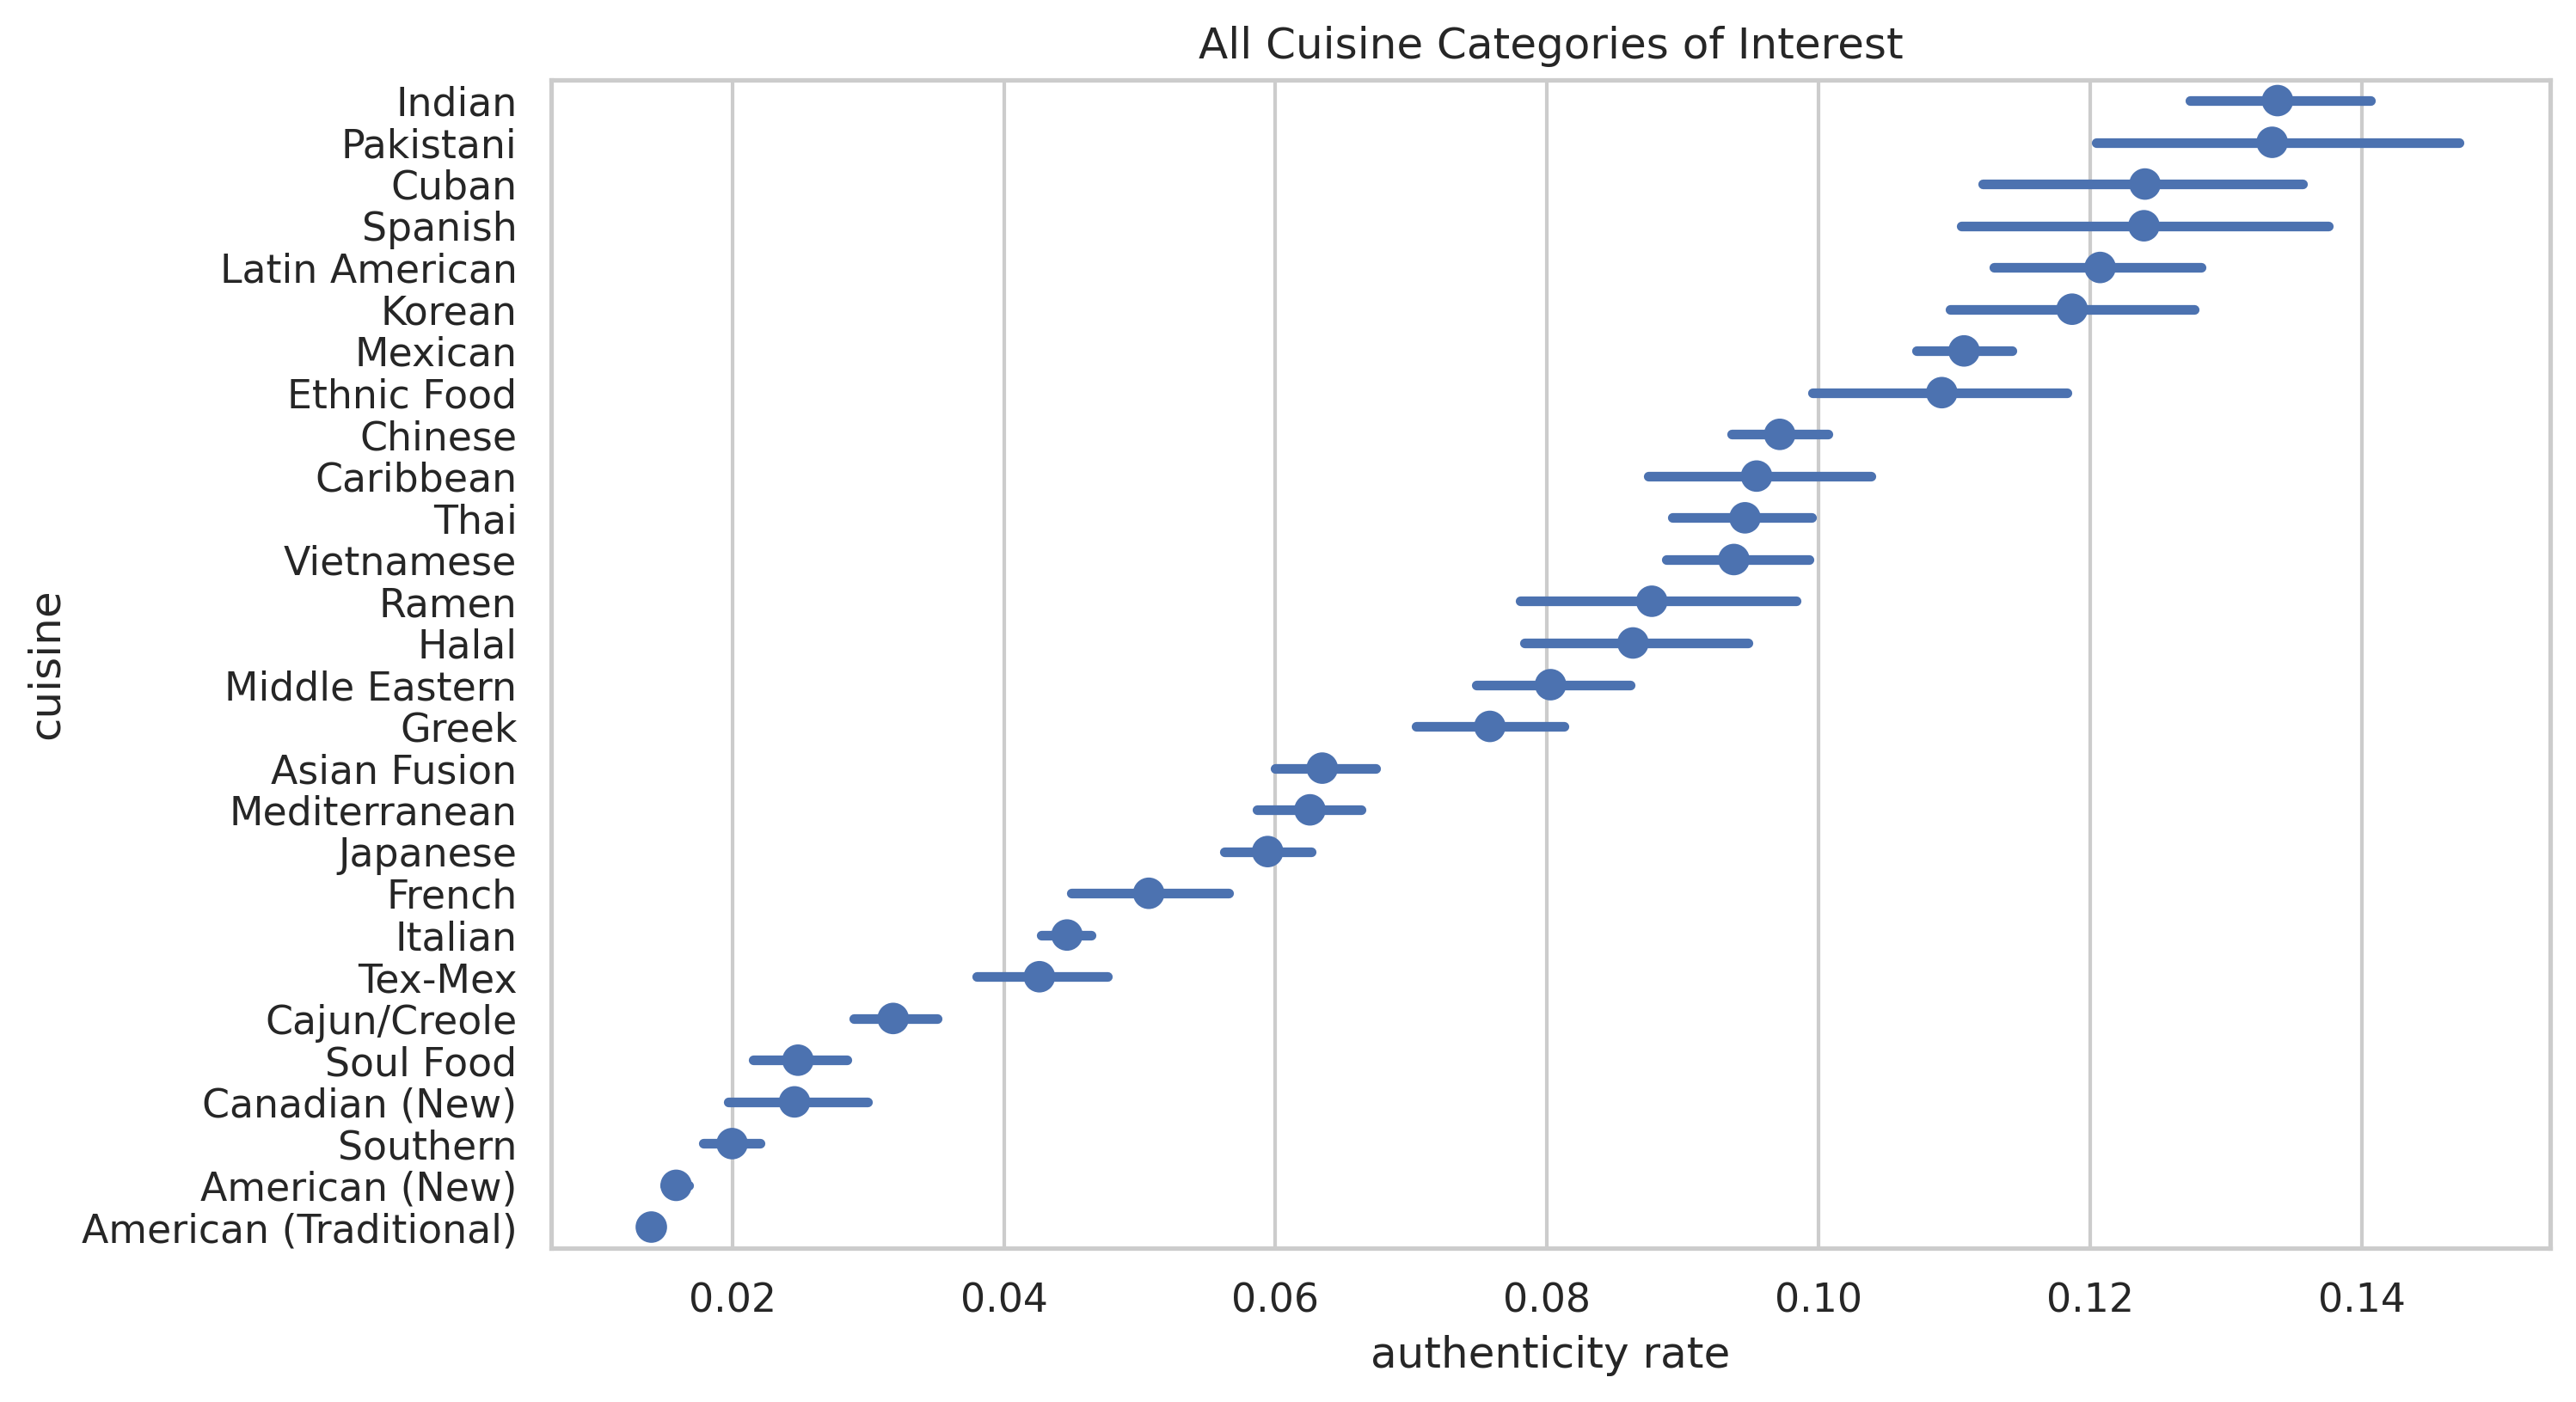

In [73]:
sns.set(rc={"figure.dpi":300, 'figure.figsize':(10, 6)})
sns.set_style("whitegrid")
ranks = authentic_rate_df.groupby("cuisine")["authenticity rate"].mean().sort_values()[::-1].index
sns.pointplot(x="authenticity rate", y="cuisine", data=authentic_rate_df, order=ranks, 
             join=False)
plt.title("All Cuisine Categories of Interest")
plt.show()

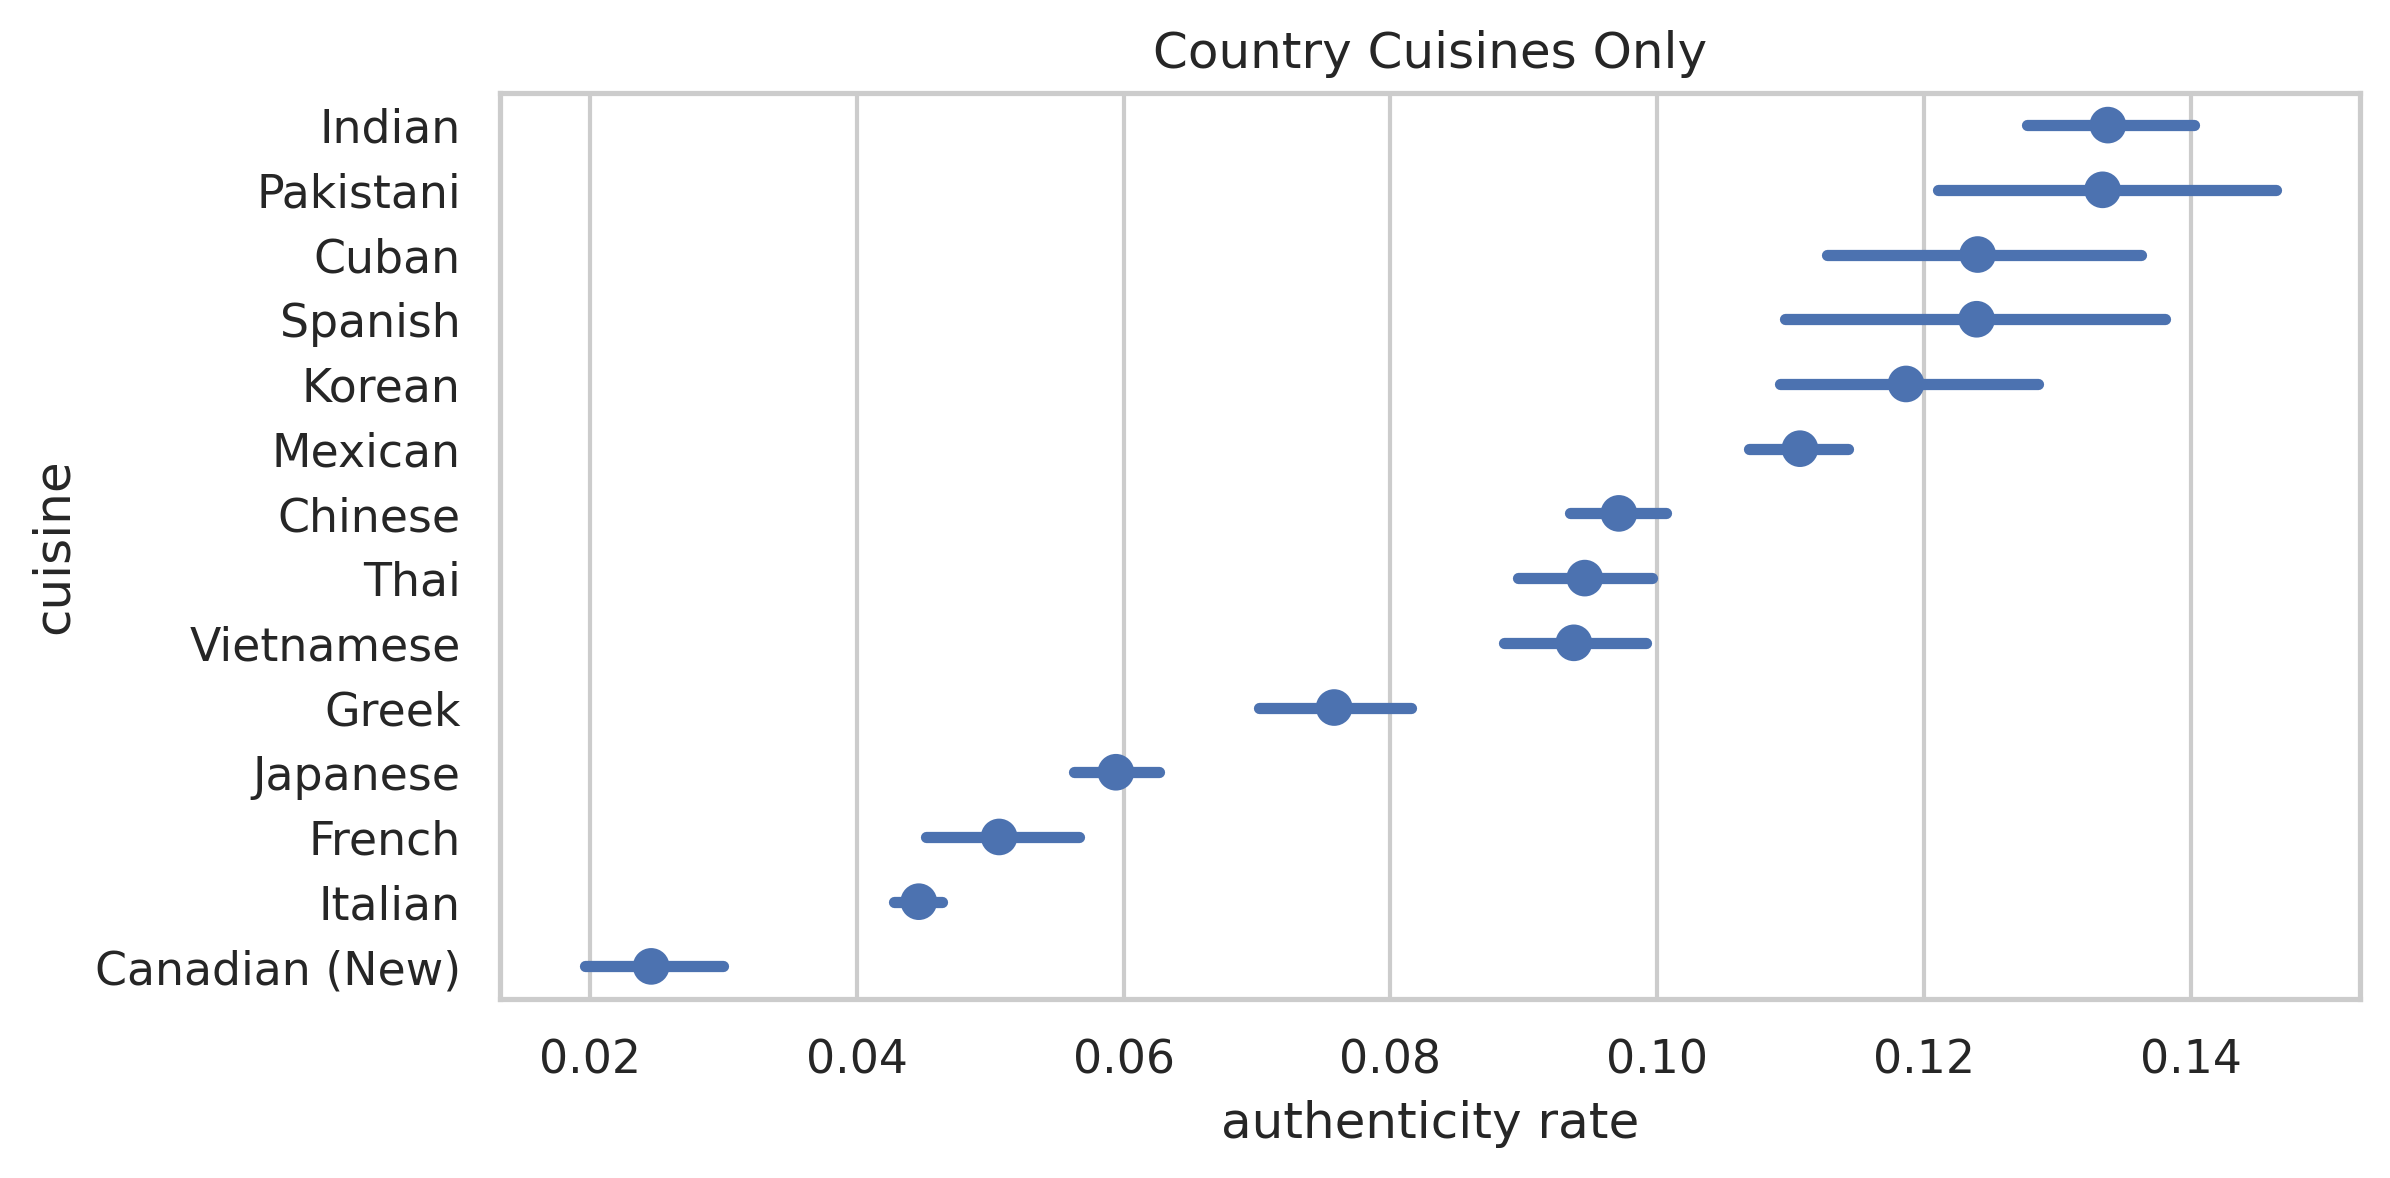

In [69]:
sns.set(rc={"figure.dpi":300, 'figure.figsize':(8, 4)})
sns.set_style("whitegrid")
country_authentic_rate_df = authentic_rate_df[authentic_rate_df['cuisine'].isin(set(country_of_origin.keys()))]
ranks = country_authentic_rate_df.groupby("cuisine")["authenticity rate"].mean().sort_values()[::-1].index
sns.pointplot(x="authenticity rate", y="cuisine", data=country_authentic_rate_df, order=ranks, 
             join=False)
plt.title("Country Cuisines Only")
plt.show()

### Correlation between mentions of authenticity and restaurant's avg score

Signficance of correlation
- Three asterisks: p < 0.001, two asterisks: p < 0.01, one asterisk: p < 0.1.

In [94]:
correlation = Counter()
significance = Counter()
for cuisine in categories_of_interest: 
    this_cuisine = authentic_rate_df[authentic_rate_df['cuisine'] == cuisine]
    corr, sig = pearsonr(this_cuisine['star rating'].to_list(), this_cuisine['authenticity rate'].to_list())
    correlation[cuisine] = corr
    significance[cuisine] = sig
sig_suffix = defaultdict(str)
for tup in correlation.most_common(): 
    suffix = ''
    if round(significance[tup[0]], 3) < 0.001: 
        suffix = '***'
    elif round(significance[tup[0]], 3) < 0.01: 
        suffix = '**'
    elif round(significance[tup[0]], 3) < 0.1: 
        suffix = '*'
    sig_suffix[tup[0]] = suffix
    print(tup[0], round(tup[1], 3), suffix)

Tex-Mex 0.429 ***
Mexican 0.418 ***
Italian 0.295 ***
Ethnic Food 0.245 ***
Caribbean 0.234 ***
Spanish 0.23 ***
Canadian (New) 0.225 ***
Middle Eastern 0.215 ***
Latin American 0.209 ***
Mediterranean 0.186 ***
Greek 0.183 ***
American (Traditional) 0.176 ***
Chinese 0.174 ***
Thai 0.17 ***
Southern 0.163 ***
American (New) 0.147 ***
Halal 0.141 **
Asian Fusion 0.124 ***
Cuban 0.122 *
French 0.111 *
Vietnamese 0.109 **
Soul Food 0.095 *
Cajun/Creole 0.084 *
Japanese 0.081 **
Ramen 0.054 
Indian 0.032 
Pakistani 0.009 
Korean -0.068 


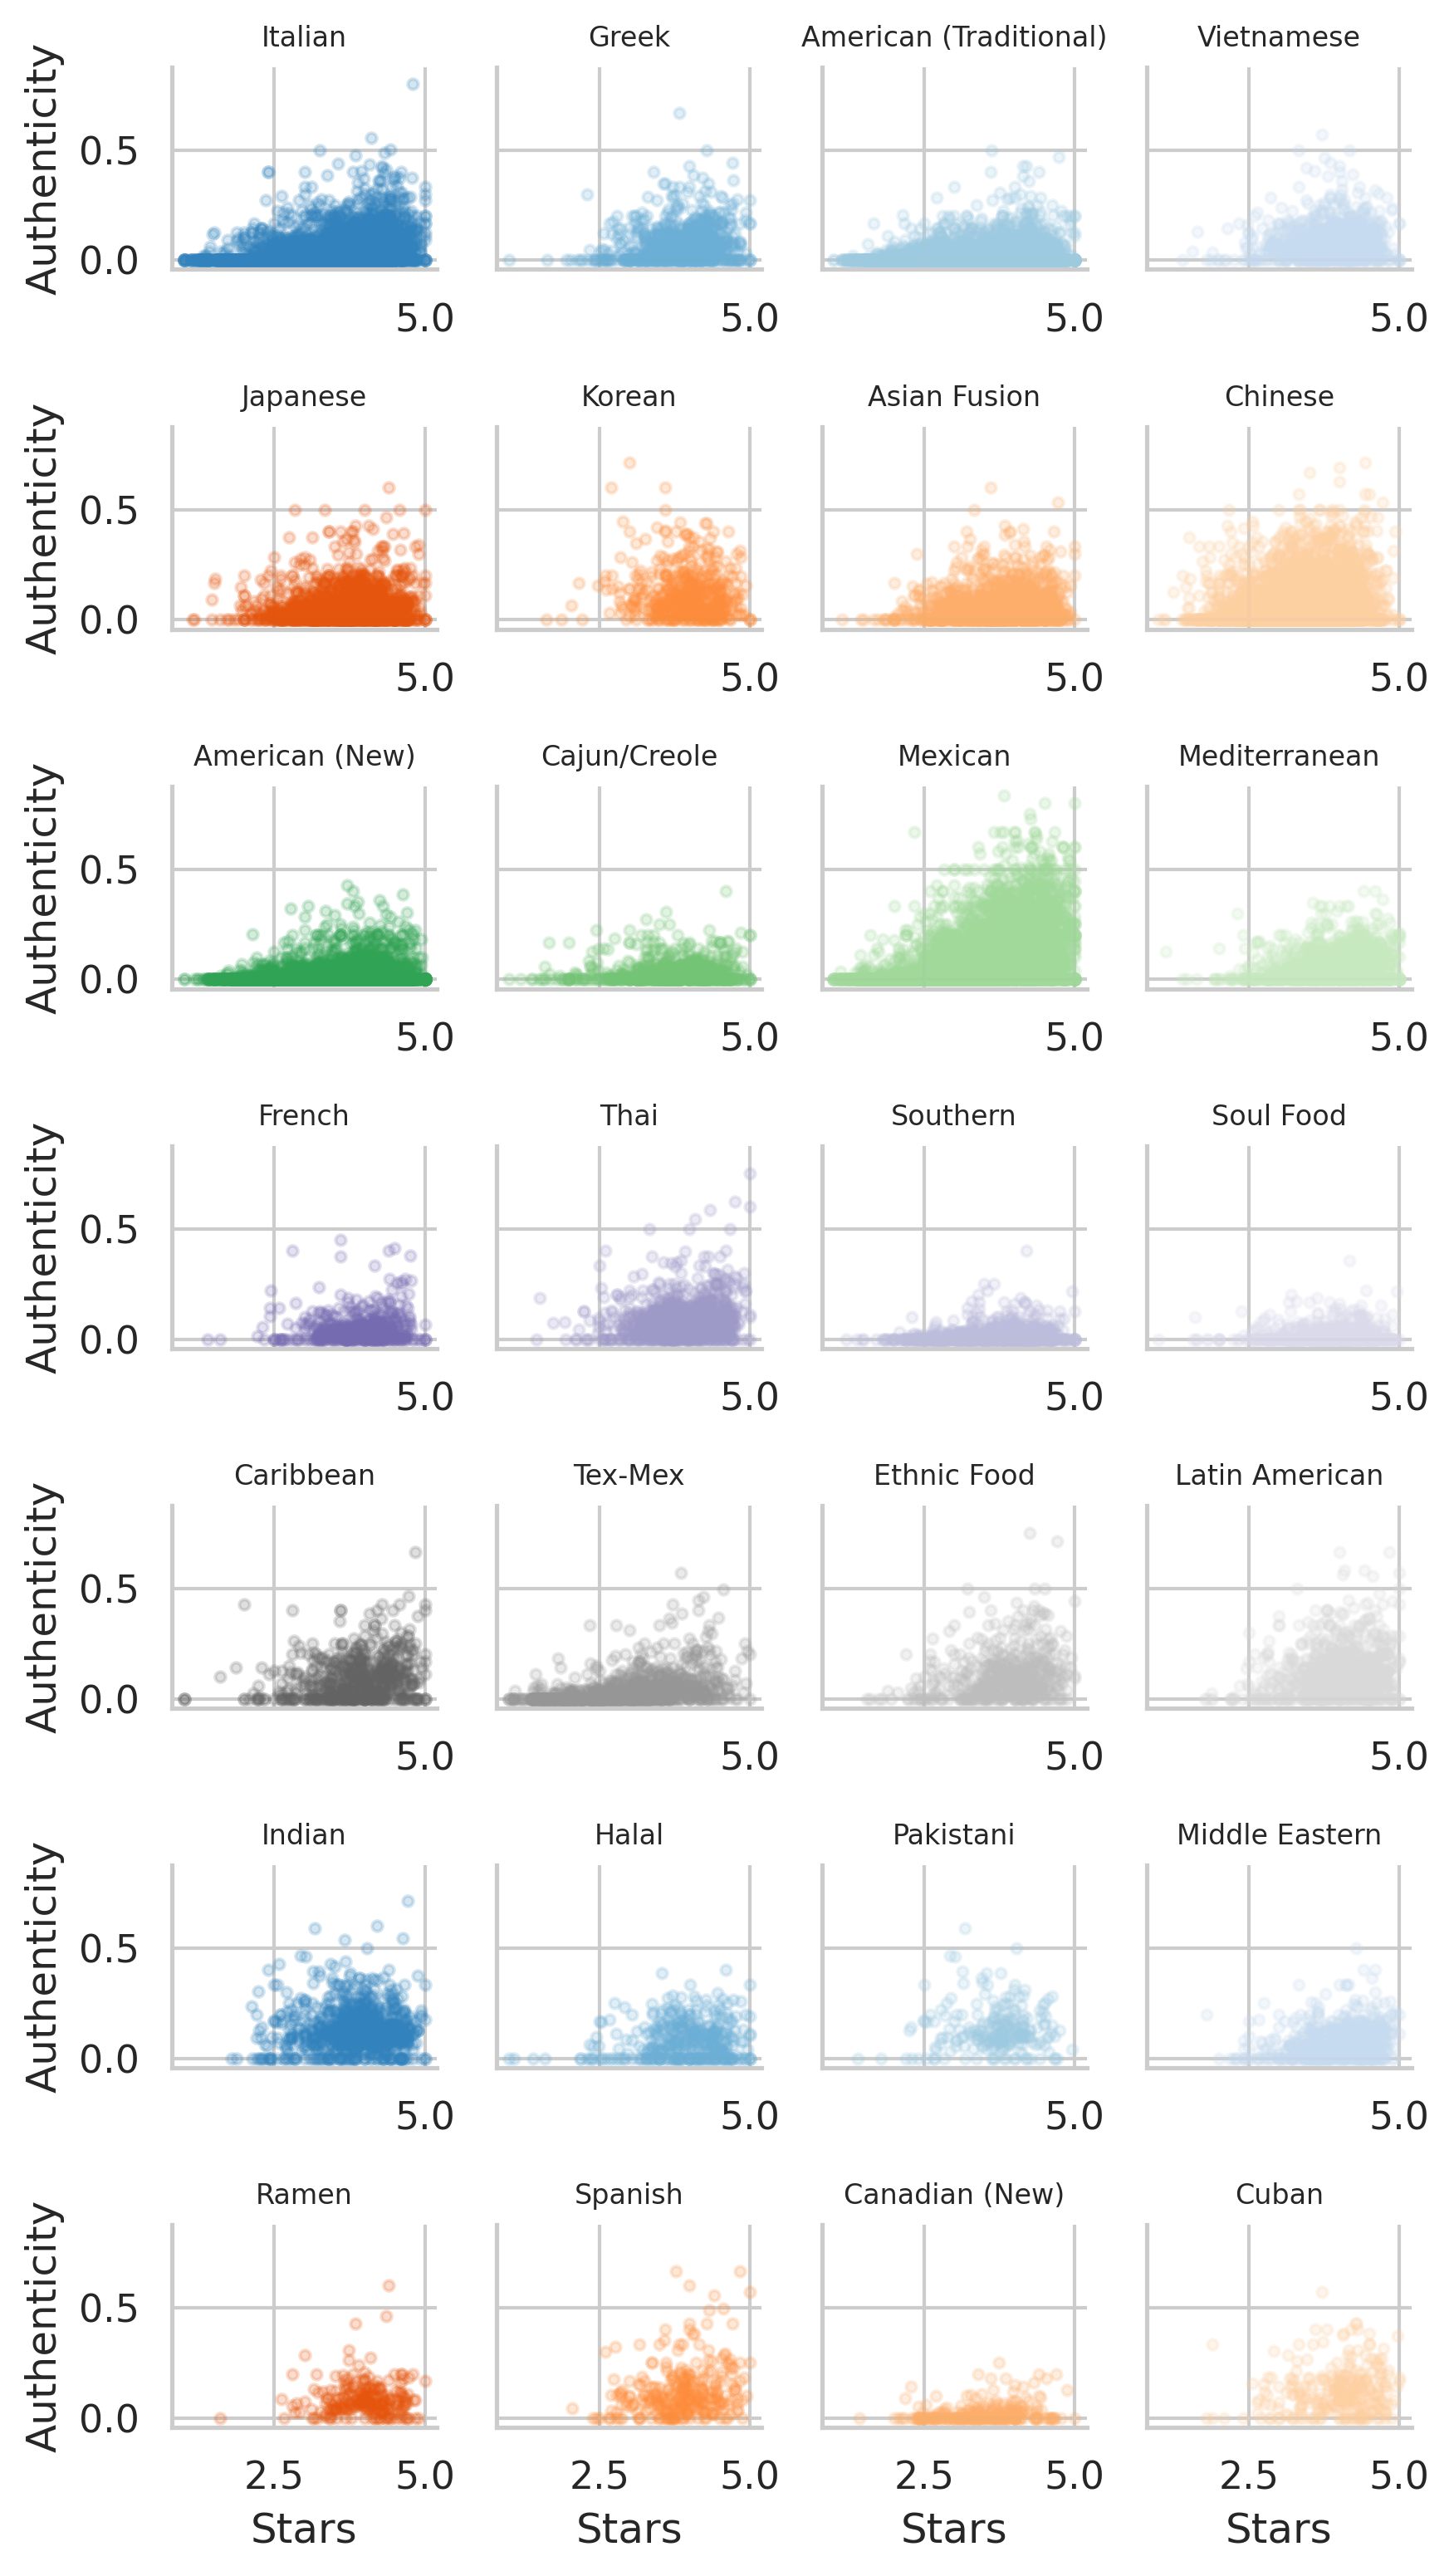

In [99]:
grid = sns.FacetGrid(authentic_rate_df, col="cuisine", hue="cuisine", palette="tab20c",
                     col_wrap=4, height=1.5, margin_titles=True)
grid.map(plt.scatter, "star rating", "authenticity rate", alpha=0.2, marker='.')
grid.set_titles("{col_name}", size=8)
grid.fig.tight_layout(w_pad=1)
grid.set_axis_labels("Stars", "Authenticity")
plt.show()